# VSD Classification Model Comparison

This notebook combines and compares the performance of various machine learning models for classifying Vascular Streak Dieback (VSD) in cocoa plants:
- Artificial Neural Network (ANN)
- Convolutional Neural Network (CNN)
- Random Forest (RF)
- Support Vector Machine (SVM)
- Graph Neural Network (GNN)

Each model is trained and evaluated on the same dataset, and their performances are compared based on accuracy, ROC-AUC, precision, recall, and F1-score.

In [1]:
# Import libraries
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import transforms
import pandas as pd

In [2]:
# Function to extract features from image (for ANN, RF, SVM)
def image_to_features(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size)  # Resize to fixed size
    img_array = np.array(img)
    features = img_array.flatten()  # Flatten to 1D array
    return features

# Function to load and preprocess image (for CNN)
def load_image(image_path, size=(64, 64)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size)  # Resize to fixed size
    img_array = np.array(img) / 255.0  # Normalize to [0,1]
    return img_array

# Function to convert image to graph (for GNN)
def image_to_graph(image_path, patch_size=8):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((64, 64))  # Resize to fixed size
    img_array = np.array(img)
    h, w, c = img_array.shape
    
    # Divide into patches
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img_array[i:i+patch_size, j:j+patch_size].flatten()
            patches.append(patch)
    
    num_patches = len(patches)
    node_features = torch.tensor(np.array(patches), dtype=torch.float)
    
    # Create edges for grid adjacency
    edges = []
    grid_size = int(np.sqrt(num_patches))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            # Right
            if j + 1 < grid_size:
                edges.append([idx, idx + 1])
                edges.append([idx + 1, idx])
            # Down
            if i + 1 < grid_size:
                edges.append([idx, idx + grid_size])
                edges.append([idx + grid_size, idx])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return Data(x=node_features, edge_index=edge_index)

# Custom Dataset class for GNN
class KakaoDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        graph = image_to_graph(self.image_paths[idx])
        graph.y = torch.tensor(self.labels[idx], dtype=torch.long)
        return graph

In [3]:
# Load data
sehat_paths = [os.path.join('Sehat', f) for f in os.listdir('Sehat') if f.endswith('.jpg')]
vsd_paths = [os.path.join('VSD', f) for f in os.listdir('VSD') if f.endswith('.jpg')]
all_paths = sehat_paths + vsd_paths
labels = [0] * len(sehat_paths) + [1] * len(vsd_paths)

print(f"Total images: {len(all_paths)}")
print(f"Sehat images: {len(sehat_paths)}")
print(f"VSD images: {len(vsd_paths)}")

Total images: 1250
Sehat images: 640
VSD images: 610


In [4]:
# Train-val split (common for all models)
X_train_paths, X_val_paths, y_train, y_val = train_test_split(all_paths, labels, test_size=0.2, random_state=42)

print(f"Train samples: {len(X_train_paths)}")
print(f"Val samples: {len(X_val_paths)}")

Train samples: 1000
Val samples: 250


In [5]:
# Prepare data for ANN, RF, SVM
features_train = []
for path in X_train_paths:
    feat = image_to_features(path)
    features_train.append(feat)
features_train = np.array(features_train)
features_train = features_train / 255.0

features_val = []
for path in X_val_paths:
    feat = image_to_features(path)
    features_val.append(feat)
features_val = np.array(features_val)
features_val = features_val / 255.0

y_train = np.array(y_train)
y_val = np.array(y_val)

In [6]:
# Prepare data for CNN
images_train = []
for path in X_train_paths:
    img = load_image(path)
    images_train.append(img)
images_train = np.array(images_train)

images_val = []
for path in X_val_paths:
    img = load_image(path)
    images_val.append(img)
images_val = np.array(images_val)

In [7]:
# Prepare data for GNN
train_dataset = KakaoDataset(X_train_paths, y_train)
val_dataset = KakaoDataset(X_val_paths, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Model 1: Artificial Neural Network (ANN)

In [8]:
# Build ANN model
ann_model = Sequential()
ann_model.add(Dense(128, input_dim=features_train.shape[1], activation='relu'))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(1, activation='sigmoid'))

# Compile model
ann_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train model
ann_history = ann_model.fit(features_train, y_train, epochs=10, batch_size=32, validation_data=(features_val, y_val), verbose=1)

# Predict on validation set
ann_y_pred_proba = ann_model.predict(features_val).flatten()
ann_y_pred = (ann_y_pred_proba > 0.5).astype(int)

# Evaluate
ann_accuracy = accuracy_score(y_val, ann_y_pred)
ann_roc_auc = roc_auc_score(y_val, ann_y_pred_proba)
ann_report = classification_report(y_val, ann_y_pred, target_names=['Sehat', 'VSD'], output_dict=True)

print(f'ANN Validation Accuracy: {ann_accuracy * 100:.2f}%')
print(f'ANN ROC-AUC: {ann_roc_auc:.2f}')
print('ANN Classification Report:')
print(classification_report(y_val, ann_y_pred, target_names=['Sehat', 'VSD']))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6273 - loss: 1.1310 - val_accuracy: 0.8120 - val_loss: 0.4245
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8458 - loss: 0.3290 - val_accuracy: 0.9240 - val_loss: 0.2126
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9268 - loss: 0.1870 - val_accuracy: 0.9000 - val_loss: 0.2550
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9414 - loss: 0.1290 - val_accuracy: 0.9440 - val_loss: 0.1326
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9562 - loss: 0.1085 - val_accuracy: 0.9520 - val_loss: 0.1259
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9803 - loss: 0.0677 - val_accuracy: 0.9120 - val_loss: 0.2094
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9714 - loss: 0.0794 - val_accuracy: 0.9600 - val_loss: 0.0901
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9856 - loss: 0.0661 - val_accuracy: 0.9240 - val_loss

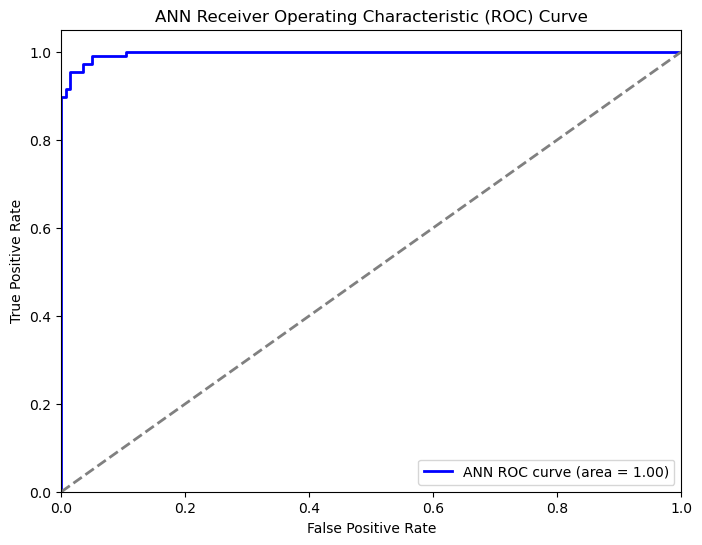

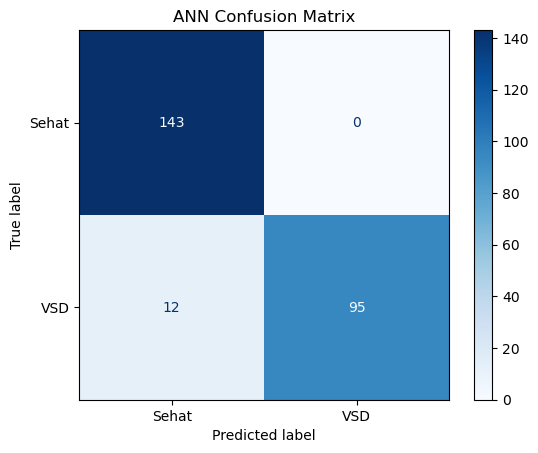

In [9]:
# ANN Plots
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, ann_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ANN ROC curve (area = {ann_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, ann_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sehat', 'VSD'])
disp.plot(cmap=plt.cm.Blues)
plt.title('ANN Confusion Matrix')
plt.show()

## Model 2: Convolutional Neural Network (CNN)

In [10]:
# Build CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train model
cnn_history = cnn_model.fit(images_train, y_train, epochs=10, batch_size=32, validation_data=(images_val, y_val), verbose=1)

# Predict on validation set
cnn_y_pred_proba = cnn_model.predict(images_val).flatten()
cnn_y_pred = (cnn_y_pred_proba > 0.5).astype(int)

# Evaluate
cnn_accuracy = accuracy_score(y_val, cnn_y_pred)
cnn_roc_auc = roc_auc_score(y_val, cnn_y_pred_proba)
cnn_report = classification_report(y_val, cnn_y_pred, target_names=['Sehat', 'VSD'], output_dict=True)

print(f'CNN Validation Accuracy: {cnn_accuracy * 100:.2f}%')
print(f'CNN ROC-AUC: {cnn_roc_auc:.2f}')
print('CNN Classification Report:')
print(classification_report(y_val, cnn_y_pred, target_names=['Sehat', 'VSD']))

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6737 - loss: 0.5981 - val_accuracy: 0.9040 - val_loss: 0.2288
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9474 - loss: 0.1702 - val_accuracy: 0.9520 - val_loss: 0.1254
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9675 - loss: 0.0823 - val_accuracy: 0.9560 - val_loss: 0.0850
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9835 - loss: 0.0516 - val_accuracy: 0.9680 - val_loss: 0.0591
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9865 - loss: 0.0392 - val_accuracy: 0.9760 - val_loss: 0.0513
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9935 - loss: 0.0217 - val_accuracy: 0.9760 - val_loss: 0.0733
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9925 - loss: 0.0249 - val_accuracy: 0.9800 - val_loss: 0.0443
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9970 - loss: 0.0078 - val_accuracy: 0.9760 - val_loss: 0.

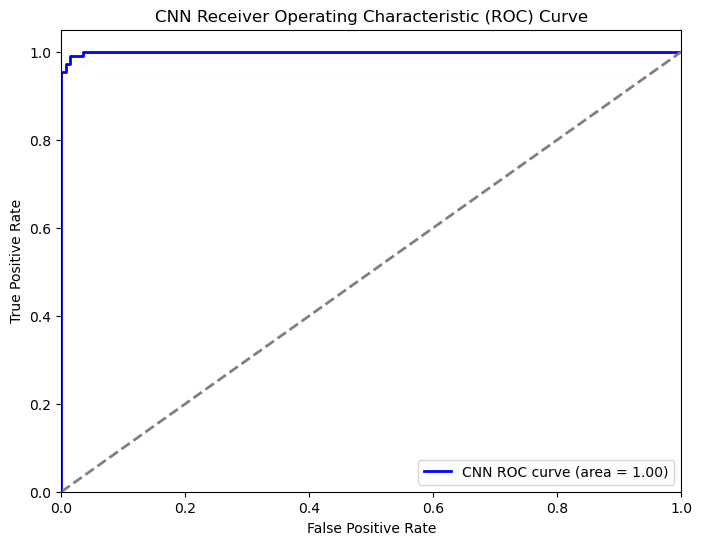

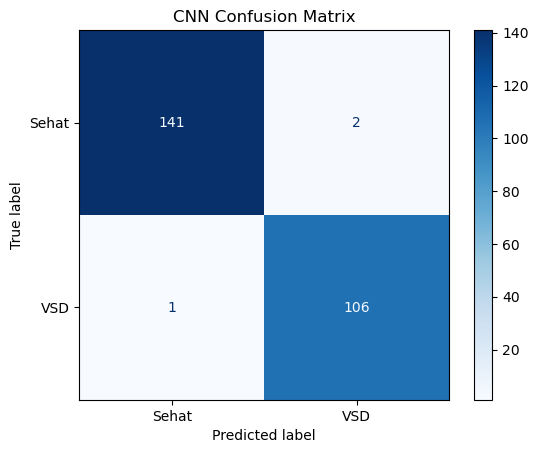

In [11]:
# CNN Plots
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, cnn_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'CNN ROC curve (area = {cnn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, cnn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sehat', 'VSD'])
disp.plot(cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.show()

## Model 3: Random Forest (RF)

In [12]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_train, y_train)

# Predict on validation set
rf_y_pred = rf_model.predict(features_val)
rf_y_pred_proba = rf_model.predict_proba(features_val)[:, 1]

# Evaluate
rf_accuracy = accuracy_score(y_val, rf_y_pred)
rf_roc_auc = roc_auc_score(y_val, rf_y_pred_proba)
rf_report = classification_report(y_val, rf_y_pred, target_names=['Sehat', 'VSD'], output_dict=True)

print(f'RF Validation Accuracy: {rf_accuracy * 100:.2f}%')
print(f'RF ROC-AUC: {rf_roc_auc:.2f}')
print('RF Classification Report:')
print(classification_report(y_val, rf_y_pred, target_names=['Sehat', 'VSD']))

RF Validation Accuracy: 96.00%
RF ROC-AUC: 0.99
RF Classification Report:
              precision    recall  f1-score   support

       Sehat       0.99      0.94      0.96       143
         VSD       0.93      0.98      0.95       107

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



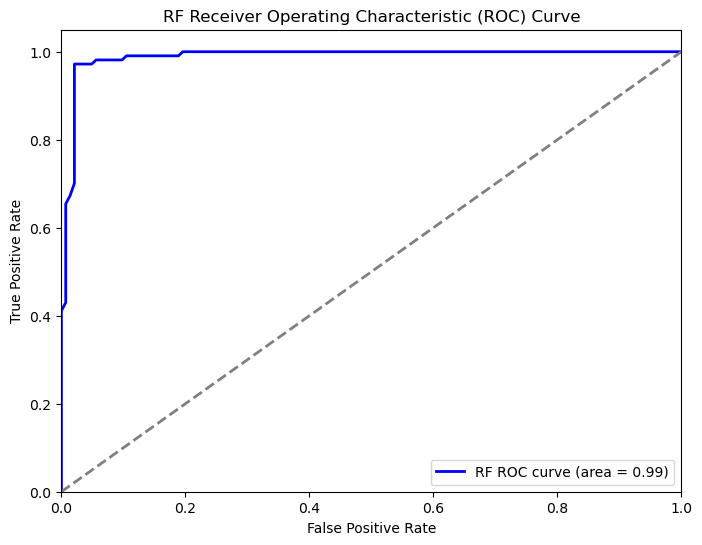

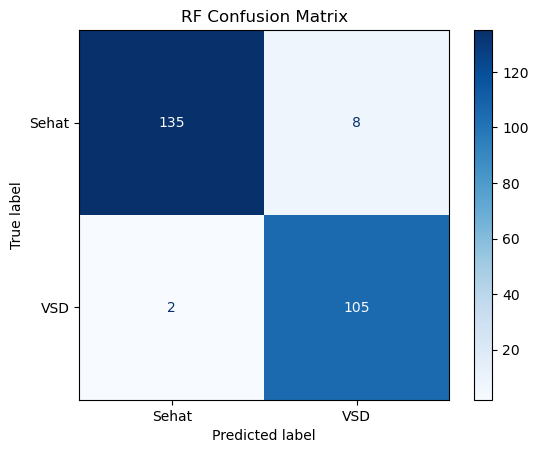

In [13]:
# RF Plots
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, rf_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'RF ROC curve (area = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RF Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, rf_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sehat', 'VSD'])
disp.plot(cmap=plt.cm.Blues)
plt.title('RF Confusion Matrix')
plt.show()

## Model 4: Support Vector Machine (SVM)

In [14]:
# Train SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(features_train, y_train)

# Predict on validation set
svm_y_pred = svm_model.predict(features_val)
svm_y_pred_proba = svm_model.predict_proba(features_val)[:, 1]

# Evaluate
svm_accuracy = accuracy_score(y_val, svm_y_pred)
svm_roc_auc = roc_auc_score(y_val, svm_y_pred_proba)
svm_report = classification_report(y_val, svm_y_pred, target_names=['Sehat', 'VSD'], output_dict=True)

print(f'SVM Validation Accuracy: {svm_accuracy * 100:.2f}%')
print(f'SVM ROC-AUC: {svm_roc_auc:.2f}')
print('SVM Classification Report:')
print(classification_report(y_val, svm_y_pred, target_names=['Sehat', 'VSD']))

SVM Validation Accuracy: 96.00%
SVM ROC-AUC: 1.00
SVM Classification Report:
              precision    recall  f1-score   support

       Sehat       0.96      0.97      0.97       143
         VSD       0.96      0.94      0.95       107

    accuracy                           0.96       250
   macro avg       0.96      0.96      0.96       250
weighted avg       0.96      0.96      0.96       250



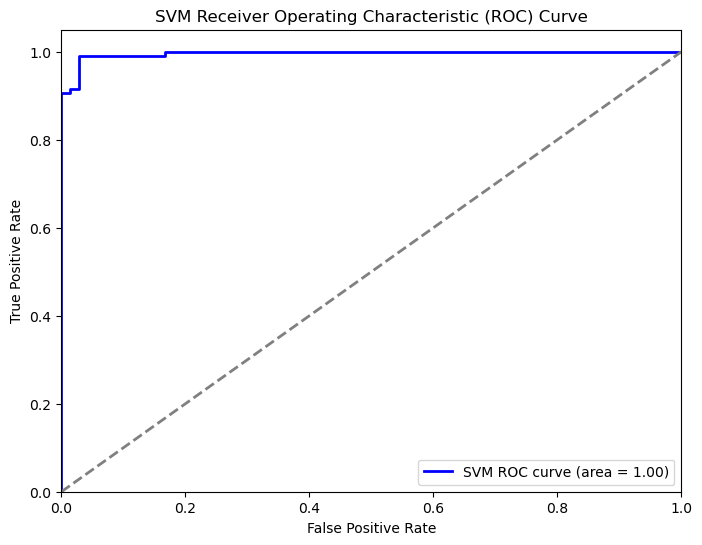

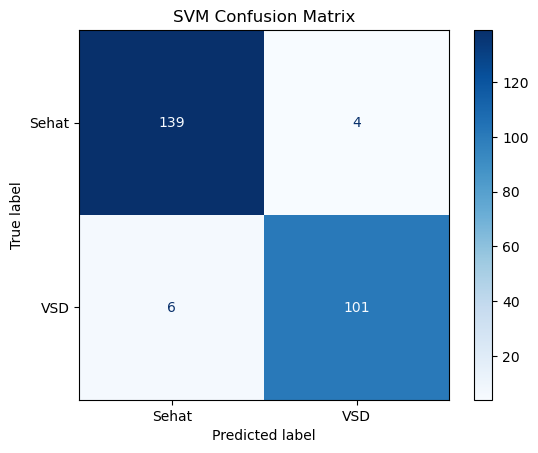

In [15]:
# SVM Plots
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, svm_y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'SVM ROC curve (area = {svm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, svm_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sehat', 'VSD'])
disp.plot(cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show()

## Model 5: Graph Neural Network (GNN)

In [16]:
# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)  # Global mean pooling per graph in batch
        x = self.fc(x)
        return x

# Model, optimizer, loss
gnn_model = GNNModel(input_dim=8*8*3, hidden_dim=64, output_dim=2)
optimizer = optim.Adam(gnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
gnn_train_losses = []
gnn_val_accuracies = []

for epoch in range(num_epochs):
    gnn_model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = gnn_model(batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    gnn_train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')

    # Validation
    gnn_model.eval()
    correct = 0
    total = 0
    gnn_all_preds = []
    gnn_all_labels = []
    gnn_all_probs = []
    with torch.no_grad():
        for batch in val_loader:
            outputs = gnn_model(batch)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += batch.y.size(0)
            correct += (predicted == batch.y).sum().item()
            gnn_all_preds.extend(predicted.cpu().numpy())
            gnn_all_labels.extend(batch.y.cpu().numpy())
            gnn_all_probs.extend(probs[:, 1].cpu().numpy())
    accuracy = 100 * correct / total
    gnn_val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy}%')

# Final evaluation
gnn_accuracy = accuracy / 100
gnn_roc_auc = roc_auc_score(gnn_all_labels, gnn_all_probs)
gnn_report = classification_report(gnn_all_labels, gnn_all_preds, target_names=['Sehat', 'VSD'], output_dict=True)

print(f'GNN Validation Accuracy: {gnn_accuracy * 100:.2f}%')
print(f'GNN ROC-AUC: {gnn_roc_auc:.2f}')
print('GNN Classification Report:')
print(classification_report(gnn_all_labels, gnn_all_preds, target_names=['Sehat', 'VSD']))

Epoch 1, Loss: 3.897115474005067
Validation Accuracy: 78.8%
Epoch 2, Loss: 0.5339132488838264
Validation Accuracy: 81.6%
Epoch 3, Loss: 0.4649390471833093
Validation Accuracy: 86.4%
Epoch 4, Loss: 0.2788182893797519
Validation Accuracy: 90.0%
Epoch 5, Loss: 0.2731793617445325
Validation Accuracy: 89.6%
Epoch 6, Loss: 0.250134260127587
Validation Accuracy: 85.2%
Epoch 7, Loss: 0.24534042599418807
Validation Accuracy: 90.0%
Epoch 8, Loss: 0.28584467167300837
Validation Accuracy: 90.0%
Epoch 9, Loss: 0.2729280696265281
Validation Accuracy: 93.2%
Epoch 10, Loss: 0.24148233243012948
Validation Accuracy: 92.0%
GNN Validation Accuracy: 92.00%
GNN ROC-AUC: 0.96
GNN Classification Report:
              precision    recall  f1-score   support

       Sehat       0.93      0.93      0.93       143
         VSD       0.91      0.91      0.91       107

    accuracy                           0.92       250
   macro avg       0.92      0.92      0.92       250
weighted avg       0.92      0.92      

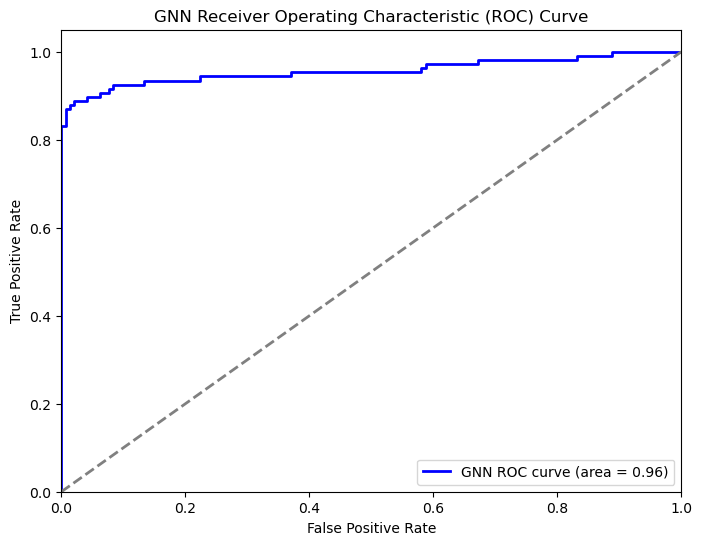

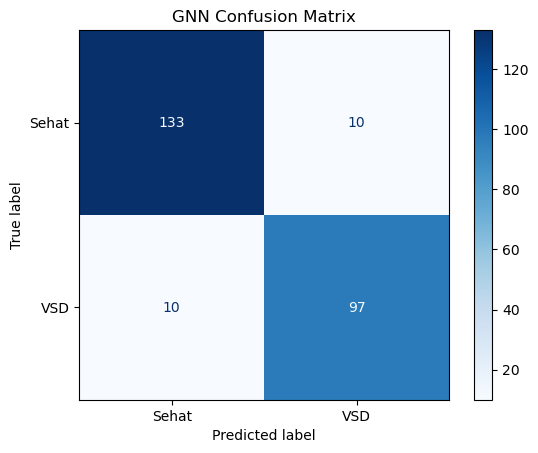

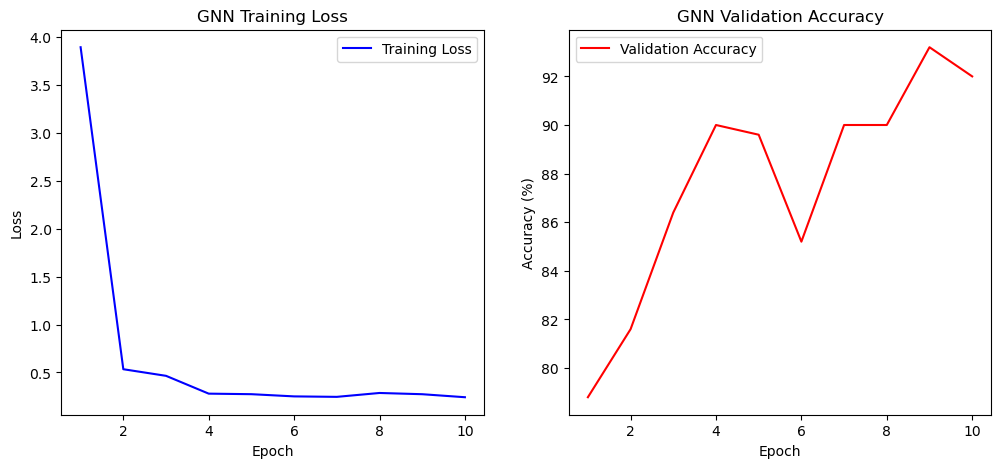

In [17]:
# GNN Plots
# ROC Curve
fpr, tpr, _ = roc_curve(gnn_all_labels, gnn_all_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'GNN ROC curve (area = {gnn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GNN Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(gnn_all_labels, gnn_all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sehat', 'VSD'])
disp.plot(cmap=plt.cm.Blues)
plt.title('GNN Confusion Matrix')
plt.show()

# Training Loss and Validation Accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, gnn_train_losses, 'b-', label='Training Loss')
plt.title('GNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, gnn_val_accuracies, 'r-', label='Validation Accuracy')
plt.title('GNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Model Comparison

Model Comparison:
  Model  Accuracy   ROC-AUC  Precision  Recall  F1-Score
0   ANN     0.952  0.996798   0.955716   0.952  0.951541
1   CNN     0.988  0.999281   0.988046   0.988  0.988007
2    RF     0.960  0.988759   0.961349   0.960  0.960117
3   SVM     0.960  0.996209   0.960026   0.960  0.959950
4   GNN     0.920  0.956866   0.920000   0.920  0.920000


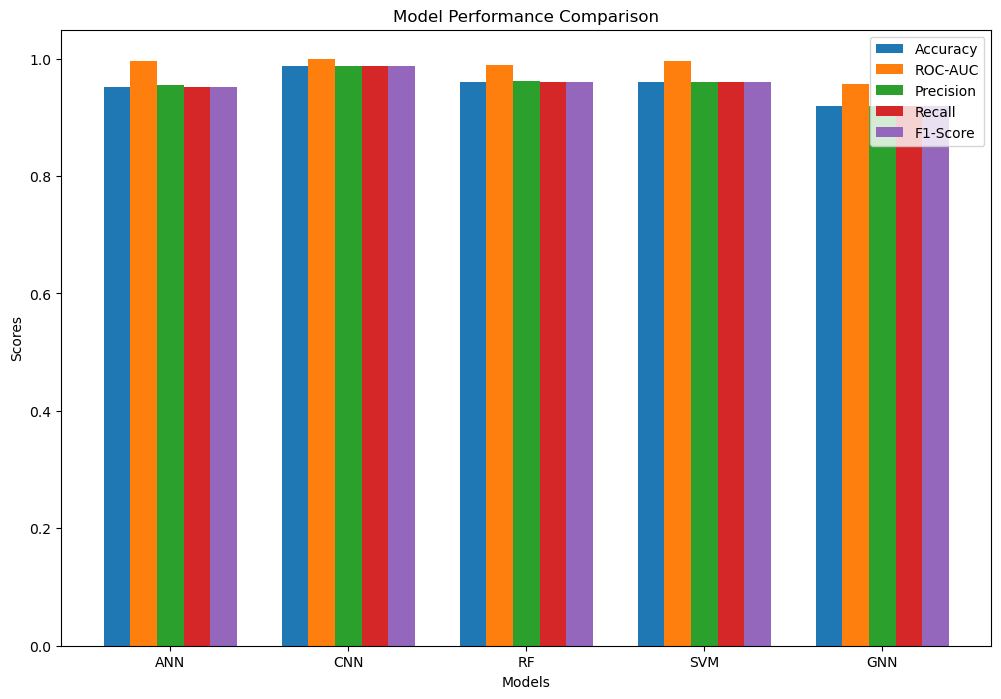


Best model by Accuracy: CNN (0.9880)
Best model by ROC-AUC: CNN (0.9993)
Best model by F1-Score: CNN (0.9880)


In [18]:
# Collect metrics
models = ['ANN', 'CNN', 'RF', 'SVM', 'GNN']
accuracies = [ann_accuracy, cnn_accuracy, rf_accuracy, svm_accuracy, gnn_accuracy]
roc_aucs = [ann_roc_auc, cnn_roc_auc, rf_roc_auc, svm_roc_auc, gnn_roc_auc]
precisions = [ann_report['weighted avg']['precision'], cnn_report['weighted avg']['precision'], rf_report['weighted avg']['precision'], svm_report['weighted avg']['precision'], gnn_report['weighted avg']['precision']]
recalls = [ann_report['weighted avg']['recall'], cnn_report['weighted avg']['recall'], rf_report['weighted avg']['recall'], svm_report['weighted avg']['recall'], gnn_report['weighted avg']['recall']]
f1_scores = [ann_report['weighted avg']['f1-score'], cnn_report['weighted avg']['f1-score'], rf_report['weighted avg']['f1-score'], svm_report['weighted avg']['f1-score'], gnn_report['weighted avg']['f1-score']]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'ROC-AUC': roc_aucs,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

print("Model Comparison:")
print(comparison_df)

# Bar plot comparison
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(models))
width = 0.15

ax.bar(x - 2*width, accuracies, width, label='Accuracy')
ax.bar(x - width, roc_aucs, width, label='ROC-AUC')
ax.bar(x, precisions, width, label='Precision')
ax.bar(x + width, recalls, width, label='Recall')
ax.bar(x + 2*width, f1_scores, width, label='F1-Score')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.show()

# Identify best model
best_accuracy_idx = np.argmax(accuracies)
best_roc_auc_idx = np.argmax(roc_aucs)
best_f1_idx = np.argmax(f1_scores)

print(f"\nBest model by Accuracy: {models[best_accuracy_idx]} ({accuracies[best_accuracy_idx]:.4f})")
print(f"Best model by ROC-AUC: {models[best_roc_auc_idx]} ({roc_aucs[best_roc_auc_idx]:.4f})")
print(f"Best model by F1-Score: {models[best_f1_idx]} ({f1_scores[best_f1_idx]:.4f})")